In [192]:
import pandas as pd
import numpy as np
import pickle as pkl
from scipy import stats
from collections import defaultdict

#modeling
from sklearn.model_selection import train_test_split
import xgboost as xgb
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from classification_functions import  conf_matrix, plot_roc
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, fbeta_score, auc
from xgboost import XGBClassifier

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
def XGBoost(X_train, y_train, X_val, y_val, depth, l_rate, subsample,  min_weight, col_sample):

    params = { 
                'n_estimators': 20000,
                'max_depth': depth,
                'objective':'multi:softprob',
                'num_classes' :3,  
                'learning_rate': l_rate, 
                'subsample': subsample,
                'min_child_weight':min_weight,
                'colsample_bytree':col_sample,
                'random_state' : 0,
                'verbosity' : 0,
                'n_jobs' : -1}

    gbm = XGBClassifier()
    gbm.set_params(**params)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_val)
    
    print(f'XGBoost with params:\n'
          f'max_depth = {depth}\n'
          f'learning_rate = {l_rate}\n'
          f'subsample = {subsample}\n'
          f'min_child_weight = {min_weight}\n'
          f'colsample_bytree = {col_sample}\n'
          '\n'
          f'Has an f1 score of: {round(f1_score( y_val, preds, average="macro"), 3)}'
         )
          
    return gbm

def XGBoost_baseline(X_train, y_train):
              
    gbm = XGBClassifier()
    gbm.fit(X_train, y_train)
    
          
    return gbm

def get_f1(model, X_val, y_val):
    preds = model.predict(X_val)
    
    return f1_score( y_val, preds, average="macro")
    

Load data

In [101]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')
#df.info()

In [105]:
X = df[['database_count', 'Age1stCode', 'YearsCodePro', 'Age','YearsCode', 'EdLevel', 
         'Gender', 'UndergradMajor', 'Region', 
        'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X = pd.get_dummies(X, drop_first = True)
print(X.columns)

Index(['database_count', 'Age1stCode', 'YearsCodePro', 'Age', 'YearsCode',
       'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_None', 'EdLevel_Prof',
       'EdLevel_Some Univ', 'EdLevel_Student', 'Gender_Woman',
       'Gender_gender non-conforming', 'UndergradMajor_Comp Sci/Eng',
       'UndergradMajor_Eng', 'UndergradMajor_Health/Nat Sci',
       'UndergradMajor_Human/Social Sci', 'UndergradMajor_Info Tech/Sys',
       'UndergradMajor_Math/Stats', 'UndergradMajor_None',
       'UndergradMajor_Web Dev', 'Region_Asia', 'Region_Australia',
       'Region_Baltics', 'Region_CIS', 'Region_Europe', 'Region_M East',
       'Region_N America', 'Region_S America', 'Region_other', 'Hobbyist_Yes',
       'back-end_Yes', 'full-stack_Yes', 'front-end_Yes', 'desktop_Yes',
       'mobile_Yes', 'DevOps_Yes', 'Database admin_Yes', 'Designer_Yes',
       'System admin_Yes', 'Student_Yes', 'Other Occupation_Yes',
       'Retired Dev_Yes', 'Sometimes Code at Work_Yes', 'JavaScript_Yes',
       'Python_Ye

### Fix Class Imbalance

Try ADASYN Oversampling

In [106]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn,y_adasyn, test_size=0.2, random_state=42)
X_train_adasyn, X_val_adasyn, y_train_adasyn, y_val_adasyn = train_test_split(X_train_adasyn,y_train_adasyn, test_size=0.25, random_state=42)

xgb_adasyn = XGBoost(X_train_adasyn, y_train_adasyn,X_val_adasyn, y_val_adasyn, 10, 0.3, 0.8, 3, 0.8)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  The variable **evals_result** will contain:


XGBoost with params:
max_depth = 10
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.848


Try SMOTE Oversampling

In [135]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

X_train_smoted, X_test_smoted, y_train_smoted, y_test_smoted = train_test_split(X_smoted,y_smoted, test_size=0.2, random_state=42)
X_train_smoted, X_val_smoted, y_train_smoted, y_val_smoted = train_test_split(X_train_smoted, y_train_smoted, test_size=0.25, random_state=42)

xgb_smoted = XGBoost(X_train_smoted, y_train_smoted, X_val_smoted, y_val_smoted, 10, 0.3, 0.8, 3, 0.8)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  The variable **evals_result** will contain:


XGBoost with params:
max_depth = 10
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.849


In [196]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

Try Undersampling

In [136]:
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,y)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under,y_under, test_size=0.2, random_state=42)
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under,y_train_under, test_size=0.25, random_state=42)

xgb_under = XGBoost(X_train_under, y_train_under, X_val_under, y_val_under, 10, 0.3, 0.8, 3, 0.8)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  The variable **evals_result** will contain:


XGBoost with params:
max_depth = 10
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.742


SMOTE performed the best

pickle balanced dataframe

In [156]:
# df = pd.concat((X_smoted,y_smoted), axis=1)
# df.to_pickle('../Data/survey_data_cleaned_balanced.pkl')
# #print(df)

### Feature Selection

In [161]:
#from itertools import islice
def remove_features(X_train, y_train, X_val, y_val, basef1):
    feats_remove = []
    keep_remove = 1
    col_list = list(X_train.columns)
    #print(col_list)
    d = {el:0 for el in col_list}
    
    while keep_remove == 1:
        #idx = 0
        for idx in range(len(col_list)+1):
            removed = col_list[idx]
            #print(removed)
            
            removed_col_list = col_list.copy()
            removed_col_list.remove(removed)
            
            #print(removed_col_list)
            model = XGBoost_baseline(X_train[removed_col_list], y_train)
            
            d[removed] = get_f1(model, X_val[removed_col_list], y_val)
        
        max_f1_key = max(d, key=d.get)
        max_f1_val = d[max_f1_key]
        print(max_f1_key, max_f1_val)
        
        if max_f1_val >= basef1:
            col_list.remove(max_f1_key)
            feats_remove.append(max_f1_key)
            print(feats_remove)
            d = {el:0 for el in col_list}
        else:
            keep_remove = 0
    
    return feats_remove

In [162]:
xgb_smoted_base = XGBoost_baseline(X_train_smoted, y_train_smoted)
basef1 = get_f1(xgb_smoted_base, X_val_smoted, y_val_smoted)
print(basef1)

0.6401506528729594


In [163]:
feats_remove = remove_features(X_train_smoted, y_train_smoted, X_val_smoted, y_val_smoted, basef1)

KeyboardInterrupt: 

In [126]:
X_train_adasyn.drop(labels= feats_remove , axis=1, inplace=True)
X_val_adasyn.drop(labels= feats_remove , axis=1, inplace=True)
X_test_adasyn.drop(labels= feats_remove , axis=1, inplace=True)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Hyperparameter Tuning

In [143]:
#increase max_depth
xgb2_smoted = XGBoost(X_train_smoted, y_train_smoted ,X_val_smoted, y_val_smoted, 30, 0.3, 0.8, 3, 0.8)

XGBoost with params:
max_depth = 30
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.854


In [146]:
#increase max_depth more
xgb3_smoted = XGBoost(X_train_smoted, y_train_smoted ,X_val_smoted, y_val_smoted, 100, 0.3, 0.8, 3, 0.8)

XGBoost with params:
max_depth = 100
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.853


In [151]:
#decrease max depth & increase n_estimators
xgb4_smoted = XGBoost(X_train_smoted, y_train_smoted ,X_val_smoted, y_val_smoted, 20, 0.3, 0.8, 3, 0.8)

XGBoost with params:
max_depth = 20
learning_rate = 0.3
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.854


In [152]:
#decrease learning rate
xgb5_smoted = XGBoost(X_train_smoted, y_train_smoted ,X_val_smoted, y_val_smoted, 20, 0.05, 0.8, 3, 0.8)

XGBoost with params:
max_depth = 20
learning_rate = 0.05
subsample = 0.8
min_child_weight = 3
colsample_bytree = 0.8

Has an f1 score of: 0.857


In [159]:
#decrease subsample
xgb6_smoted = XGBoost(X_train_smoted, y_train_smoted ,X_val_smoted, y_val_smoted, 20, 0.05, 0.7, 3, 0.8)

KeyboardInterrupt: 

### Final Model

Choose xgb_adasyn with an f1 score of: 0.85

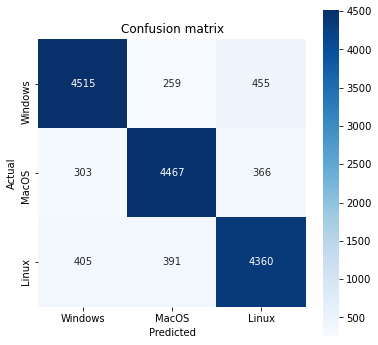

In [198]:
probs = xgb5_smoted.predict(X_test_smoted)
conf = confusion_matrix(y_test_smoted, probs)
plt.figure(figsize=(6,6))
conf1 = sns.heatmap(conf, cmap=plt.cm.get_cmap('Blues'), annot=True, square=True, fmt='d',
               xticklabels=['Windows', 'MacOS', 'Linux'],
               yticklabels=['Windows', 'MacOS', 'Linux'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
conf1.figure.savefig('../Graphs/confmatrix.png')

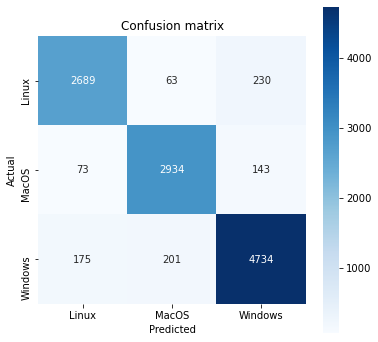

In [200]:
probs = xgb5_smoted.predict(X_test)
conf = confusion_matrix(y_test, probs)
plt.figure(figsize=(6,6))
conf2 = sns.heatmap(conf, cmap=plt.cm.get_cmap('Blues'), annot=True, square=True, fmt='d',
               xticklabels=['Linux', 'MacOS', 'Windows'],
               yticklabels=['Linux', 'MacOS', 'Windows'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
conf2.figure.savefig('../Graphs/confmatrix2.png')

In [194]:
print(f1_score( y_test_smoted, probs, average='macro'))
print(precision_score( y_test_smoted, probs, average='macro'))
print(recall_score( y_test_smoted, probs, average='macro'))

0.8596252815566073
0.8596515161932045
0.8596045210304517


Pickle final model

In [171]:
with open("../Models/xgb_balanced.pkl", "wb") as f:
    pkl.dump(xgb5_smoted, f)

In [130]:
X_train_adasyn.columns

Index(['database_count', 'Age1stCode', 'YearsCodePro', 'Age', 'YearsCode',
       'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_Prof', 'EdLevel_Some Univ',
       'EdLevel_Student', 'Gender_Woman', 'UndergradMajor_Comp Sci/Eng',
       'UndergradMajor_Eng', 'UndergradMajor_Health/Nat Sci',
       'UndergradMajor_Info Tech/Sys', 'UndergradMajor_Math/Stats',
       'UndergradMajor_None', 'UndergradMajor_Web Dev', 'Region_Asia',
       'Region_Australia', 'Region_Europe', 'Region_M East',
       'Region_N America', 'Region_S America', 'Region_other', 'back-end_Yes',
       'front-end_Yes', 'desktop_Yes', 'mobile_Yes', 'DevOps_Yes',
       'Database admin_Yes', 'System admin_Yes', 'Student_Yes', 'Python_Yes',
       'SQL_Yes', 'Java_Yes', 'HTML/CSS_Yes'],
      dtype='object')